In [1]:
#STEP: Instantiate the VGG16 Convolutional base

from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet'
                 , include_top = False         #whether to include densely connected classifier or not
                 , input_shape = (150, 150, 3))

conv_base.summary()

D:\InstalledSoftware\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


58892288/58889256 [==============================] - 19s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

In [3]:
#STEP: Extract Features using the Pretrained Convolutional base

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/write/OneDrive/Deep Learning Data/cats_and_dogs_subset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))  #4,4,512 is from last layer of pretrained model
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
            directory
            , target_size = (150, 150)
            , batch_size = batch_size
            , class_mode = 'binary')
    
    iCount = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[iCount * batch_size : (iCount + 1) * batch_size] = features_batch
        labels[iCount * batch_size : (iCount + 1) * batch_size] = labels_batch
        iCount += 1
        if iCount * batch_size >= sample_count:
            break      #Note that because generators yield data indefinitely in a loop, you must break after every image has been seen once
    
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
#STEP: Defining and training the densely connected classifier

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
             loss = losses.binary_crossentropy,
             metrics = [metrics.binary_accuracy])

history_vgg16 = model.fit(train_features, train_labels,
                   epochs = 30
                   , batch_size = batch_size
                   , validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5966 - binary_accuracy: 0.6720 - val_loss: 0.4392 - val_binary_accuracy: 0.8080
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4205 - binary_accuracy: 0.8155 - val_loss: 0.3547 - val_binary_accuracy: 0.8690
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3593 - binary_accuracy: 0.8505 - val_loss: 0.3159 - val_binary_accuracy: 0.8870
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3058 - binary_accuracy: 0.8810 - val_loss: 0.2942 - val_binary_accuracy: 0.8900
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2797 - binary_accuracy: 0.8905 - val_loss: 0.2815 - val_binary_accuracy: 0.8920
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2560 - binary_accuracy: 0.9000 - val_loss: 0.2681 - val_binary_accuracy: 0.8980
Epoc

In [5]:
#STEP: Save model
model.save('vgg16_cats_and_dogs_subset_1.h5')

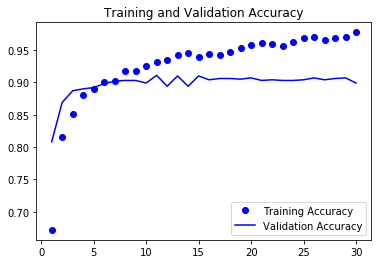

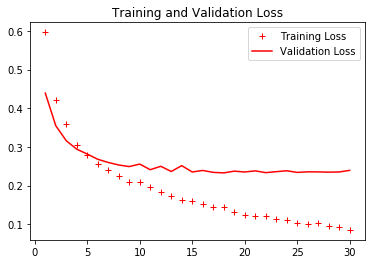

In [7]:
#STEP: Plot the results

import matplotlib.pyplot as plt

acc = history_vgg16.history['binary_accuracy']
val_acc = history_vgg16.history['val_binary_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r+', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()